# TimesFM 2.5 — Minimal Rolling Forecast (H=20)

In [1]:

# Install (only if needed)
# git clone https://github.com/google-research/timesfm.git
# cd timesfm
# pip install -e .
# cd -


In [2]:

import numpy as np
import pandas as pd
import torch
import timesfm

torch.set_float32_matmul_precision("high")

# ---- Config ----
DATA_CSV = '/Users/jan/Documents/working papers/project 1/data/btc_1h_test.csv'   # set your file path
TIMESTAMP_COL = "timestamp"
TARGET_COL = "close"
CONTEXT = 512        # change to 1024, 2048, ...
HORIZON = 1

OUT_LONG = "/Users/jan/Documents/working papers/project 1/data/timesfm25_long.csv"
OUT_WIDE = "/Users/jan/Documents/working papers/project 1/data/timesfm25_wide.csv"
OUT_STEP1 = "/Users/jan/Documents/working papers/project 1/data/timesfm25_step1.csv"

USE_COMPILE = torch.cuda.is_available()  # simple: compile only on CUDA


/Users/jan/Documents/working papers/project 1/venvtimesfm/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/jan/Documents/working papers/project 1/venvtimesfm/lib/python3.13/site-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/Context.cpp:85.)
  _C._set_float32_matmul_pr

In [3]:

# ---- Data ----
df = pd.read_csv(DATA_CSV, usecols=[TIMESTAMP_COL, TARGET_COL]).rename(
    columns={TIMESTAMP_COL:"timestamp", TARGET_COL:"target"}
)
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
df = df.dropna(subset=["timestamp","target"]).sort_values("timestamp").reset_index(drop=True)

vals = df["target"].to_numpy(np.float32)
ts = df["timestamp"].to_numpy()
if len(vals) < CONTEXT + HORIZON + 1:
    raise ValueError("Not enough rows for CONTEXT+HORIZON")
idxs = np.arange(CONTEXT-1, len(vals)-HORIZON)   # base indices t
contexts = [vals[i-CONTEXT+1:i+1] for i in idxs] # list of 1D arrays


In [4]:
import json, os, torch
from safetensors.torch import load_file
import timesfm

CKPT_DIR = "/Users/jan/.cache/huggingface/hub/models--google--timesfm-2.5-200m-pytorch/snapshots/1d952420fba87f3c6dee4f240de0f1a0fbc790e3"

# 1. Read config and instantiate the high-level wrapper
with open(os.path.join(CKPT_DIR, "config.json"), "r") as f:
    cfg_raw = json.load(f)

model = timesfm.TimesFM_2p5_200M_torch(**cfg_raw)

# 2. Load weights directly into the internal nn.Module
core = model.model  # inner torch module
state_dict = load_file(os.path.join(CKPT_DIR, "model.safetensors"), device="cpu")
missing, unexpected = core.load_state_dict(state_dict, strict=False)
print("Missing keys:", len(missing), "Unexpected:", len(unexpected))

# 3. Compile and configure
forecast_cfg = timesfm.ForecastConfig(
    max_context=max(CONTEXT, 32),
    max_horizon=max(HORIZON, 1),
    normalize_inputs=True,
    use_continuous_quantile_head=False,
    force_flip_invariance=True,
    infer_is_positive=True,
    fix_quantile_crossing=True,
)

USE_COMPILE = torch.cuda.is_available()
model.compile(forecast_cfg, torch_compile=USE_COMPILE)



Missing keys: 0 Unexpected: 0


In [5]:
# 4. Forecast
point, quant = model.forecast(horizon=HORIZON, inputs=contexts)
print("Forecast done. point:", point.shape, "quant:", None if quant is None else quant.shape)

Forecast done. point: (9488, 1) quant: (9488, 1, 10)


In [7]:

# Outputs
N, H = point.shape
base_ts = ts[idxs]                               # (N,)
future_ts = [ts[i+1:i+1+H] for i in idxs]        # list of (H,)
true_vals = [vals[i+1:i+1+H] for i in idxs]      # list of (H,)

# long
rows = []
for n in range(N):
    for h in range(H):
        rows.append((base_ts[n], h+1, future_ts[n][h], float(point[n,h]), float(true_vals[n][h])))
df_long = pd.DataFrame(rows, columns=["base_timestamp","horizon_step","forecast_timestamp","y_pred","y_true"])

# wide
df_wide = pd.DataFrame({
    "base_timestamp": base_ts
})
for h in range(H):
    df_wide[f"y_pred_h{h+1}"] = point[:,h]
for h in range(H):
    df_wide[f"y_true_h{h+1}"] = [float(x[h]) for x in true_vals]

# step1
df_step1 = df_long[df_long["horizon_step"]==1][["forecast_timestamp","y_true","y_pred"]].rename(
    columns={"forecast_timestamp":"timestamp"}
).reset_index(drop=True)

df_long.to_csv(OUT_LONG, index=False)
df_wide.to_csv(OUT_WIDE, index=False)
df_step1.to_csv(OUT_STEP1, index=False)

print("Saved:", OUT_LONG, OUT_WIDE, OUT_STEP1, sep="\n")


Saved:
/Users/jan/Documents/working papers/project 1/data/timesfm25_long.csv
/Users/jan/Documents/working papers/project 1/data/timesfm25_wide.csv
/Users/jan/Documents/working papers/project 1/data/timesfm25_step1.csv


In [10]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt


PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '/Users/jan/Documents/working papers/project 1'))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from utils.metrics import evaluate_forecast
from utils.plotting import plot_equity_no_tc_vs_bh


results = evaluate_forecast(
    y_true=df_step1["y_true"],
    y_pred=df_step1["y_pred"],
    timestamps=df_step1["timestamp"],
    starting_capital=100_000.0,
    threshold=0.0005,     
    fee_rate=0.0003       
)

print(f"Final equity (no TC): {results['final_equity_no_tc']:.4f}")
print(f"Final equity (with TC): {results['final_equity_tc']:.4f}")
print(f"Total fees paid: {results['total_fees_paid']:.4f}")

print(f"ARC: {results['arc']:.4f}")
print(f"ASD: {results['asd']:.4f}")
print(f"IR*: {results['ir_star']:.4f}")
print(f"IR**: {results['ir_starstar']:.4f}")
print(f"Max DD: {results['mdd']:.4f}")

print(f"% time long: {results['pct_long']:.4f}")
print(f"% time short: {results['pct_short']:.4f}")
print(f"% time flat: {results['pct_flat']:.4f}")

print(f"Trades long: {results['trades_long']}")
print(f"Trades short: {results['trades_short']}")
print(f"Trades flat: {results['trades_flat']}")
print(f"Trades total: {results['trades_total']}")


Final equity (no TC): 1353282.5075
Final equity (with TC): 74799.2163
Total fees paid: 436822.3826
ARC: -0.2353
ASD: 0.7942
IR*: -0.2963
IR**: -0.0894
Max DD: 0.7804
% time long: 0.4431
% time short: 0.4308
% time flat: 0.1261
Trades long: 2403
Trades short: 2422
Trades flat: 974
Trades total: 5799


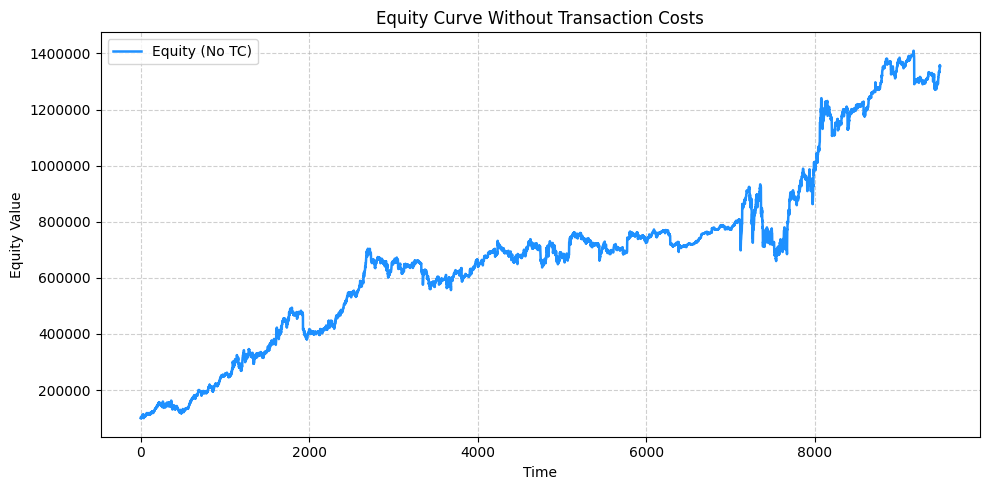

In [12]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# Extract equity curve (no transaction costs)
equity_no_tc = results["equity_no_tc"]

plt.figure(figsize=(10, 5))
plt.plot(equity_no_tc.index, equity_no_tc.values, label="Equity (No TC)",
         color="dodgerblue", linewidth=1.8)

plt.title("Equity Curve Without Transaction Costs")
plt.xlabel("Time")
plt.ylabel("Equity Value")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

# Disable scientific notation on y-axis
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
plt.ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()